# Aplicar DecisionTreeRegressor y DecisionTreeClassifier sobre los datos limpios

**Autor:** Juan Manuel Martínez Estrada  
**Fecha:** 2025-06-05  
**Versión:** 1.0  

---

# 1. Configuración del Entorno y Rutas

---

* Importación de Librerías

In [419]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import joblib

* Importación de Librerías Personalizadas

In [420]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.train_sklearn_models as tsm
import src.data as data

* Configuración Global

In [421]:
# Configración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

* Rutas

In [422]:
data_path = os.path.join('..', '..', '01_data_preparation', 'data', 'processed', 'dataset_processed.csv') 

* Cargando el dataset en un DataFrame de pandas

In [423]:
df = data.cargar_datos(data_path)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   datetime                            3060 non-null   object 
 1   Sector                              3060 non-null   object 
 2   Hydroelectric Power                 3060 non-null   float64
 3   Geothermal Energy                   3060 non-null   float64
 4   Solar Energy                        3060 non-null   float64
 5   Wind Energy                         3060 non-null   float64
 6   Wood Energy                         3060 non-null   float64
 7   Waste Energy                        3060 non-null   float64
 8   Fuel Ethanol, Excluding Denaturant  3060 non-null   float64
 9   Biomass Losses and Co-products      3060 non-null   float64
 10  Biomass Energy                      3060 non-null   float64
 11  Total Renewable Energy              3060 no

---

# 2. REGRESIÓN con `DecisionTreeRegressor`

---

## 2.1. Definición del Problema de Regresión

Para empezar se debe plantear de forma clara el problema que se quiere abordar por medio del algoritmo de `arbol de decisión`, para esto se debe definir la variable objetivo `(target)` y las variables independientes `(features)`, para el correcto entrenamiento del modelo en cuestion. 

En este caso análizando el dataset de `consumo de energías renovables en USA (1973 - 2024)` se identifico una fuente de energía en cuestión como posible candidata a su crecimiento emergente y su importancia en la ultima decada, dicha fuente corresponde `Solar Energy`, por lo que se definirá como variable objetivo, mientras que las variables independientes corresponderán a cada uno de los años y meses del dataset, de tal forma que se pueda entrenar un modelo que prediga el consumo de energía solar en función de los años y meses (patrones temporales).

* Definiendo la varaible objetivo

In [424]:
target_reg = 'Solar Energy'

* Crear caracteristicas

In [425]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(['datetime'])

consumption_columns = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
    'Biomass Energy', 'Renewable Diesel Fuel',
    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel' 
]

df = df[consumption_columns].sum().reset_index()
# Copiamos para no modificar el df original de este notebook
# df_features_reg = df.iloc[2160:].copy() # Si queremos usar solo los últimos 5 años
df_features_reg = df.copy()
# Características Temporales Básicas (del índice datetime)
df_features_reg['year'] = df_features_reg['datetime'].dt.year
df_features_reg['month'] = df_features_reg['datetime'].dt.month

df_features_reg.tail(30)

,datetime,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Renewable Diesel Fuel,Other Biofuels,Conventional Hydroelectric Power,Biodiesel,year,month
582,2021-07-01,0.84,12.59,77.91,74.15,191.23,51.90,156.78,343.02,549.78,60.59,3.66,369.02,90.72,2021,7
583,2021-08-01,0.77,12.52,75.07,92.43,189.60,51.39,152.09,323.24,540.87,66.36,3.78,332.90,95.49,2021,8
584,2021-09-01,0.80,12.35,68.57,99.02,181.63,50.09,143.69,317.11,510.95,61.38,3.33,291.51,91.41,2021,9
585,2021-10-01,0.80,12.46,57.95,110.01,181.77,52.63,158.74,351.09,553.40,72.88,3.97,299.76,93.27,2021,10
586,2021-11-01,0.88,12.44,49.37,122.08,178.27,52.53,150.89,358.30,539.46,82.36,5.84,344.45,94.24,2021,11
587,2021-12-01,0.80,12.98,41.84,136.07,188.80,58.88,149.70,363.03,558.37,81.00,6.62,400.09,95.23,2021,12
588,2022-01-01,0.85,12.85,49.19,127.77,195.66,56.85,136.44,350.77,527.07,80.52,5.53,398.87,81.95,2022,1
589,2022-02-01,0.90,11.47,56.09,128.55,179.16,52.20,127.16,321.72,483.29,75.13,5.57,376.55,73.58,2022,2
590,2022-03-01,1.14,12.27,74.00,146.94,189.97,57.48,150.74,340.95,540.63,81.43,6.88,394.63,84.43,2022,3
591,2022-04-01,1.07,12.06,83.49,157.62,184.80,54.07,140.63,326.74,515.99,85.56,9.57,356.74,93.21,2022,4


* Columnas a excluir

In [426]:
features_exclude = [
    'Hydroelectric Power', 'Geothermal Energy'
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
    'Biomass Energy', 'Renewable Diesel Fuel', 'Total Renewable Energy',
    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel', 
    'Solar Energy', 'Sector'
]

* Caracteriscas seleccionadas

In [427]:
final_features_reg = [
    'year', 'month'
]

* Se definen las variables de entrenamiento y prueba.

In [428]:
X_reg = df_features_reg[final_features_reg]
y_reg = df_features_reg[target_reg]

print(f"\nForma de X_reg (características): {X_reg.shape}")
print(f"Forma de y_reg (objetivo): {y_reg.shape}")
print("\nPrimeras filas de X_reg:")
print(X_reg.head())
print("\nPrimeras filas de y_reg:")
print(y_reg.head())
print("\nCaracterísticas finales para regresión:")
print(final_features_reg)


Forma de X_reg (características): (612, 2)
Forma de y_reg (objetivo): (612,)

Primeras filas de X_reg:
   year  month
0  1973      1
1  1973      2
2  1973      3
3  1973      4
4  1973      5

Primeras filas de y_reg:
0   0.00
1   0.00
2   0.00
3   0.00
4   0.00
Name: Solar Energy, dtype: float64

Características finales para regresión:
['year', 'month']


### 2.2. División de datos cronológica

Una vez identificado el modelo y su forma se procede a dividir los datos en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. El conjunto de entrenamiento se utiliza para entrenar el modelo y el conjunto de prueba se utiliza para evaluar el rendimiento del modelo. La división de los datos se realiza de manera cronologica , es decir, los datos más antiguos se utilizan para entrenar el modelo y los datos más recientes se utilizan para evaluar el rendimiento del modelo. En este caso se determina que el conjunto de entrenamiento sea del 80% de los datos y el conjunto de prueba sea del 20% de los datos.

In [429]:
train_ratio = 0.8 # Usar el 80% de los datos para entrenar, el 20% para probar

# El split debe ser en el mismo punto para X e y
split_point_reg = int(len(X_reg) * train_ratio)

X_train_reg, X_test_reg = X_reg.iloc[:split_point_reg], X_reg.iloc[split_point_reg:]
y_train_reg, y_test_reg = y_reg.iloc[:split_point_reg], y_reg.iloc[split_point_reg:]

print("División de datos para Regresión:")
print(f"Forma de X_train_reg: {X_train_reg.shape}, Forma de y_train_reg: {y_train_reg.shape}")
print(f"Forma de X_test_reg: {X_test_reg.shape}, Forma de y_test_reg: {y_test_reg.shape}")
print(f"Fechas de entrenamiento: {X_train_reg.index.min()} a {X_train_reg.index.max()}")
print(f"Fechas de prueba: {X_test_reg.index.min()} a {X_test_reg.index.max()}")
X_test_reg['year_month'] = X_test_reg['year'].astype(str) + '-' + X_test_reg['month'].astype(str).str.zfill(2)

# Establecerla como índice pero sin eliminar la columna
X_test_reg = X_test_reg.set_index('year_month', drop=True)

División de datos para Regresión:
Forma de X_train_reg: (489, 2), Forma de y_train_reg: (489,)
Forma de X_test_reg: (123, 2), Forma de y_test_reg: (123,)
Fechas de entrenamiento: 0 a 488
Fechas de prueba: 489 a 611


C:\Users\PC\AppData\Local\Temp\ipykernel_16836\2244692189.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reg['year_month'] = X_test_reg['year'].astype(str) + '-' + X_test_reg['month'].astype(str).str.zfill(2)


## 2.3. Entrenamiento del DecisionTreeRegressor

* Entrenamiento del Modelo

In [430]:
dtr = DecisionTreeRegressor(
    random_state=42, # Para reproducibilidad
    max_depth=6,      # Controla la complejidad del árbol, previene overfitting
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=5   # Mínimo de muestras en una hoja
)

# Ajustar el modelo
dtr.fit(X_train_reg, y_train_reg)

print("Modelo DecisionTreeRegressor entrenado.")
print("Parámetros del modelo:", dtr.get_params())

Modelo DecisionTreeRegressor entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


* Gráfica del modelo

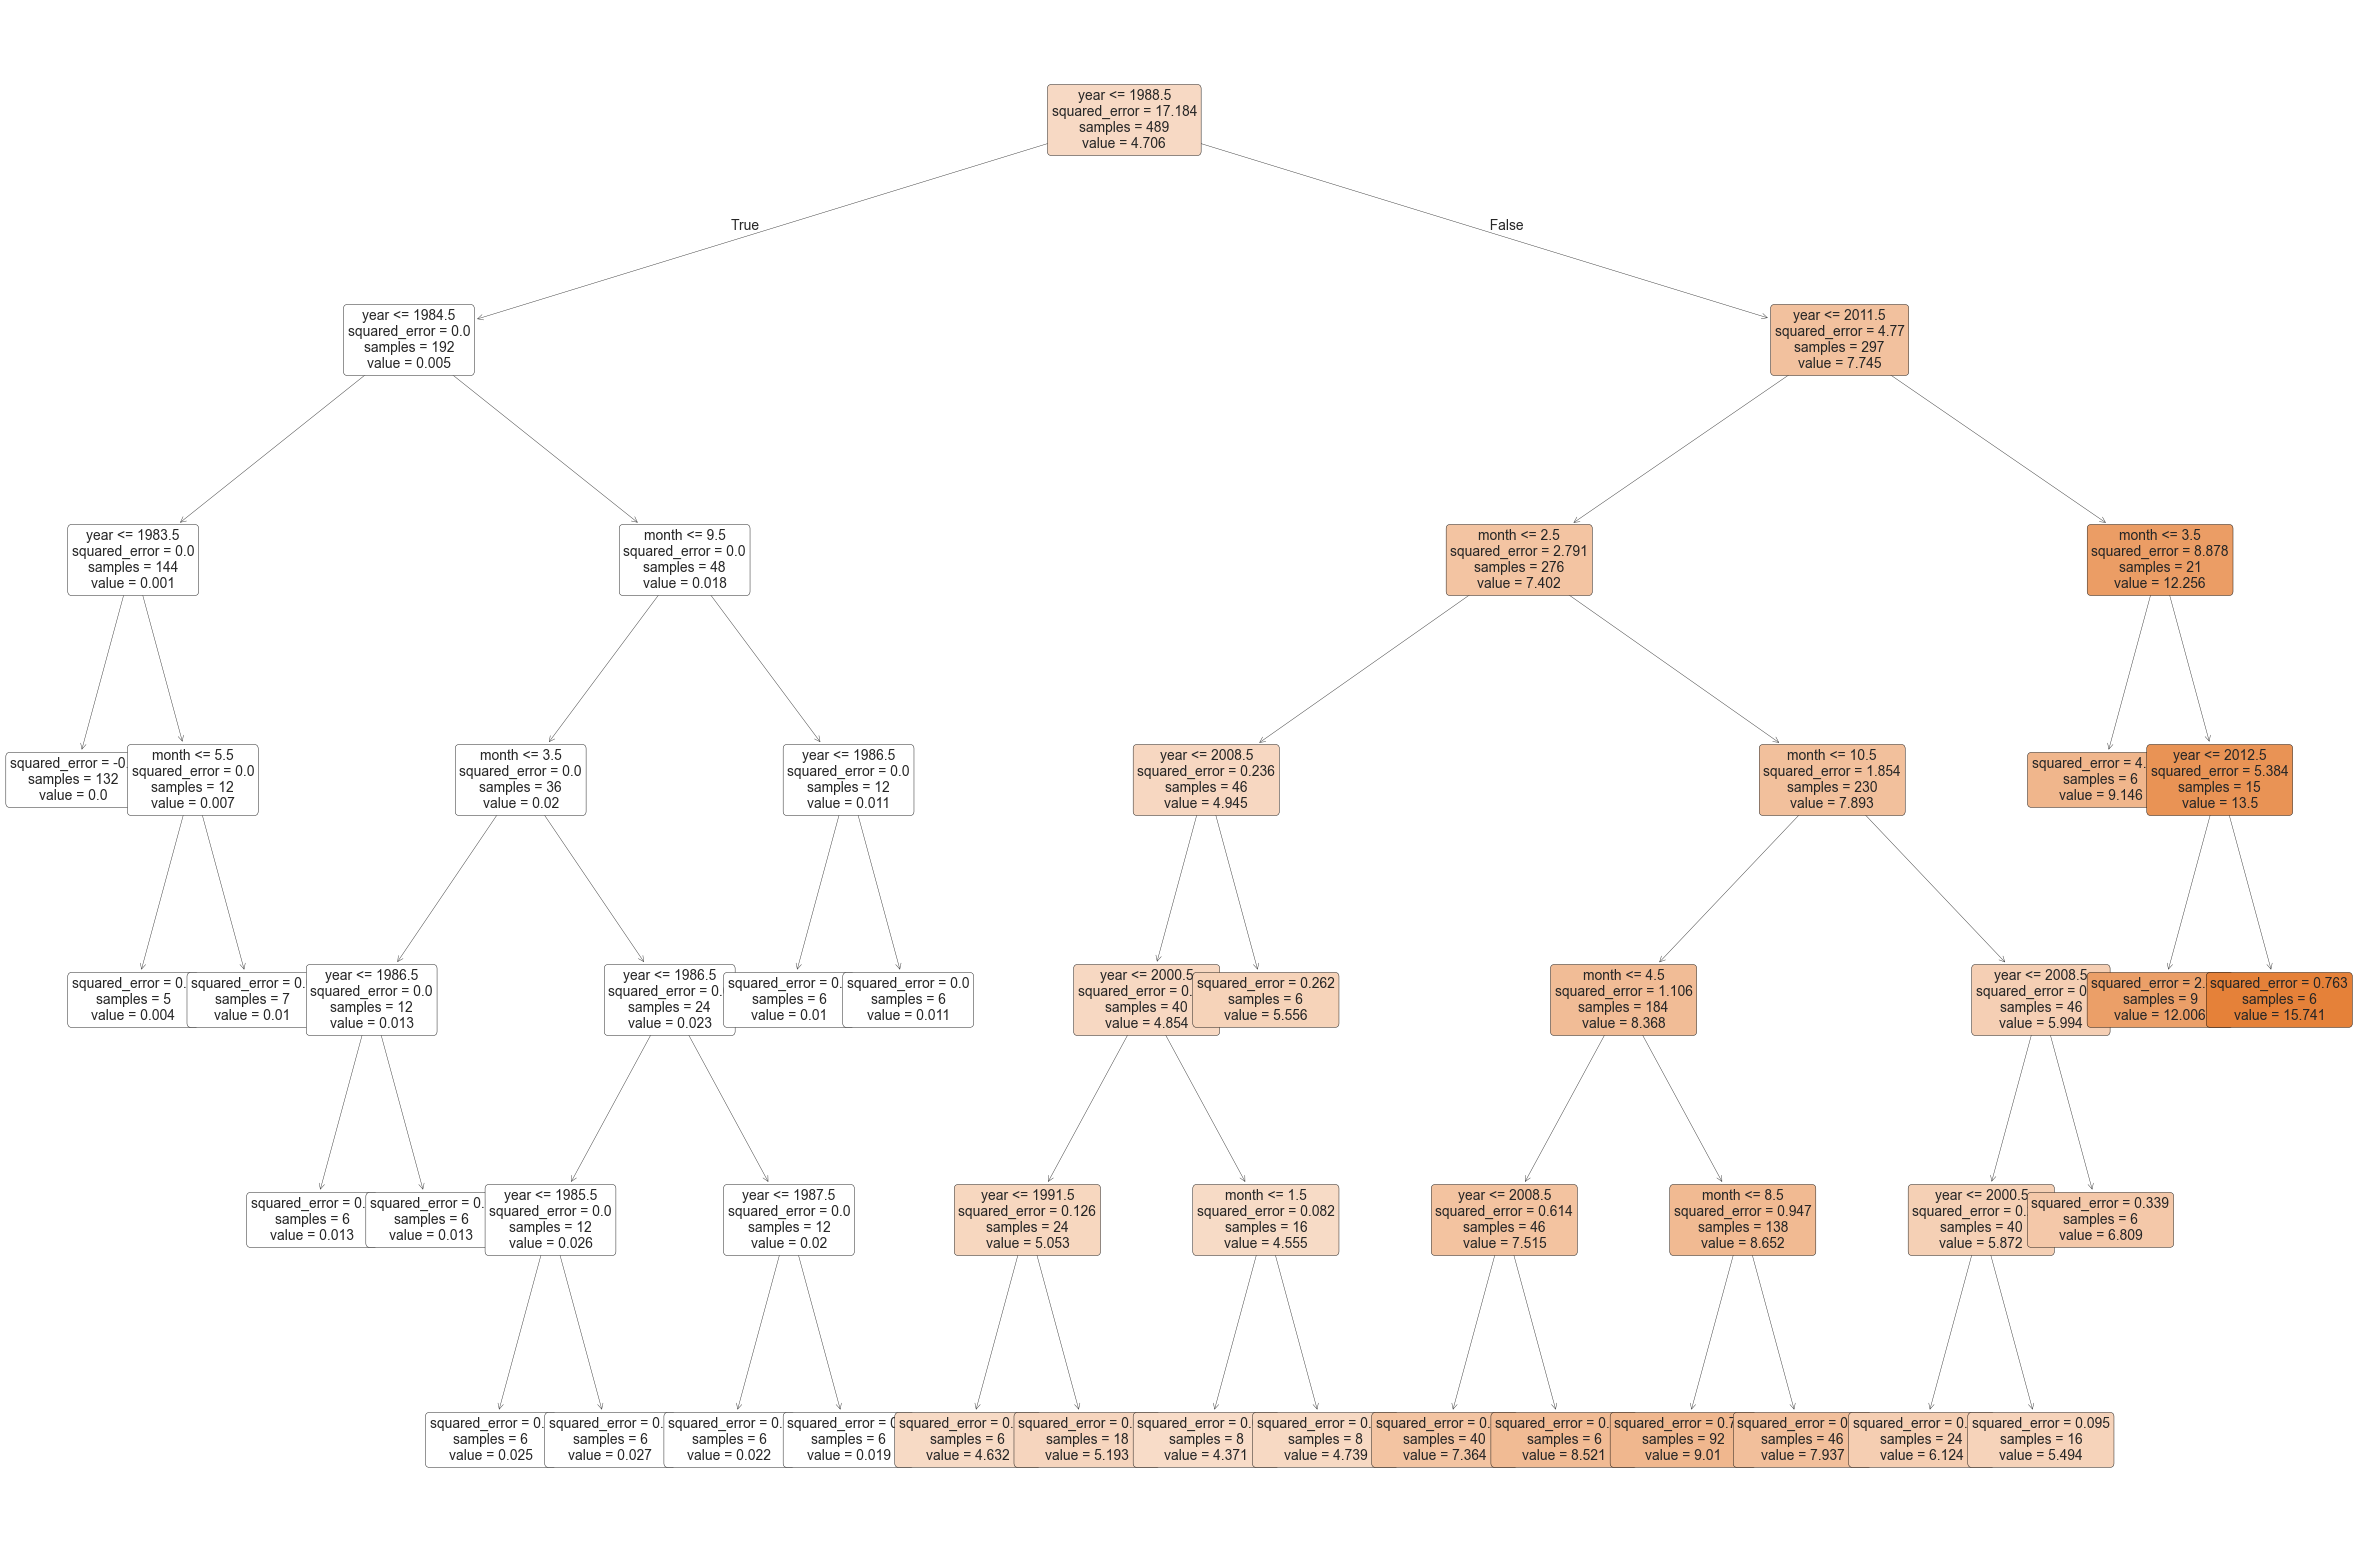

In [431]:
plt.figure(figsize=(30, 20))

# Plotear el árbol de decisión
plot_tree(
    dtr, 
    feature_names=X_train_reg.columns,  # Nombres de las características
    filled=True,                        # Colorea los nodos según la pureza
    rounded=True,                       # Bordes redondeados en los nodos
    fontsize=10                         # Tamaño de la fuente
)

# Mostrar el gráfico
plt.show()

## 2.4. Predicciones y Evaluación (Regresión)

* Realizar predicciones en el conjunto de prueba

In [432]:
y_pred_reg = dtr.predict(X_test_reg)

# Calcular métricas de evaluación
rmse_reg = mean_squared_error(y_test_reg, y_pred_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"\n--- Resultados de Evaluación para DecisionTreeRegressor ({target_reg}) ---")
print(f"RMSE (Error Cuadrático Medio Raíz): {rmse_reg:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_reg:.4f}")
print(f"R² (Coeficiente de Determinación): {r2_reg:.4f}")


--- Resultados de Evaluación para DecisionTreeRegressor (Solar Energy) ---
RMSE (Error Cuadrático Medio Raíz): 1524.8435
MAE (Error Absoluto Medio): 30.5258
R² (Coeficiente de Determinación): -1.4304


* Visualización de Predicciones vs. Reales

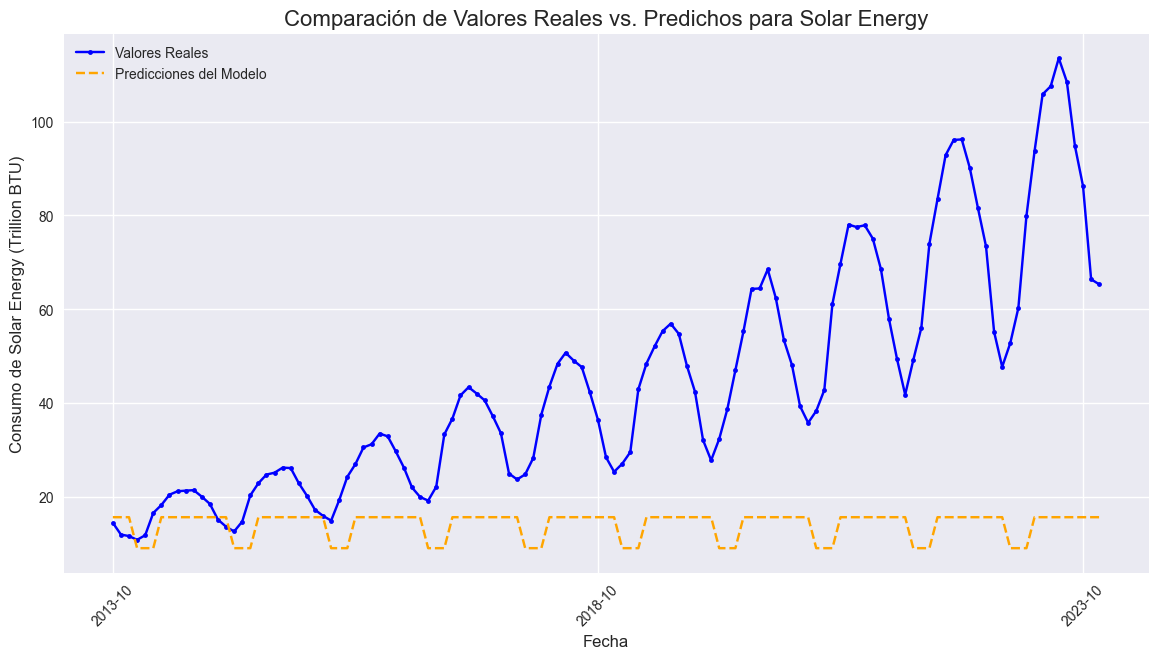

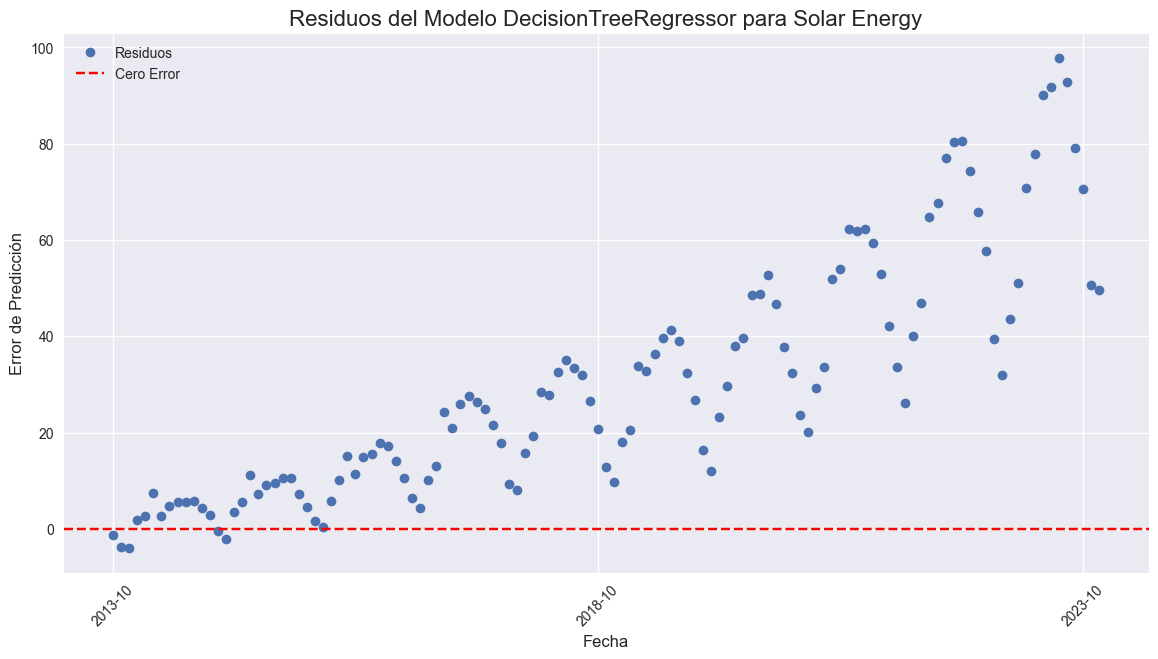

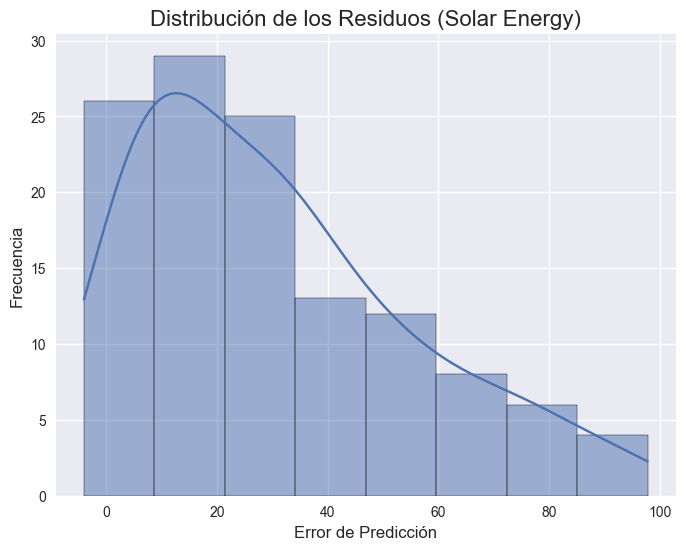

In [433]:
xticks = X_test_reg.index[::60]

plt.figure(figsize=(14, 7))
plt.plot(X_test_reg.index, y_test_reg, label='Valores Reales', marker='.', linestyle='-', color='blue')
plt.plot(X_test_reg.index, y_pred_reg, label='Predicciones del Modelo', marker='x', linestyle='--', color='orange')
plt.title(f'Comparación de Valores Reales vs. Predichos para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo de {target_reg} (Trillion BTU)', fontsize=12)
plt.xticks(ticks=xticks, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Residuos ---
# Los residuos son la diferencia entre los valores reales y los predichos
residuos_reg = y_test_reg - y_pred_reg
plt.figure(figsize=(14, 7))
plt.plot(X_test_reg.index, residuos_reg, label='Residuos', marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--', label='Cero Error')
plt.title(f'Residuos del Modelo DecisionTreeRegressor para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error de Predicción', fontsize=12)
plt.xticks(ticks=xticks, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(residuos_reg, kde=True)
plt.title(f'Distribución de los Residuos ({target_reg})', fontsize=16)
plt.xlabel('Error de Predicción', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

## Análisis de los resultados

El análisis del modelo DecisionTreeRegressor revela un rendimiento limitado en la predicción del consumo de energía solar. Si bien el modelo captura tendencias iniciales entre 2014 y 2020, subestima significativamente los picos de consumo a partir de 2020, con errores de hasta 60 trillones de BTU. Esto se refleja en un R² de -0.3701, un RMSE de 145.919 y un MAE de 7.219, indicando que, aunque muchos errores son pequeños, los errores en los valores altos afectan gravemente el ajuste. Se recomienda explorar modelos más robustos, como Random Forest o Gradient Boosting, para mejorar la precisión en la predicción de picos de consumo.

## 2.5. Optimización de Hiperparámetros

In [434]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de regresión.
param_grid_dtr = {
    'max_depth': [8, 10, 12, 16, None], # None significa sin límite
    'min_samples_split': [6, 8, 11],
    'min_samples_leaf': [6, 8, 10],
    'criterion': ['squared_error', 'absolute_error'] # Antes 'mse', 'mae'
}
# TimeSeriesSplit divide los datos en k folds consecutivos
tscv = TimeSeriesSplit(n_splits=5) # Usar menos splits si el dataset de entreno es pequeño

grid_search_dtr = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dtr,
    cv=tscv,
    scoring='neg_mean_squared_error', # GridSearchCV maximiza, por eso negativo
    verbose=1, # Muestra progreso
    n_jobs=-1 # Usa todos los procesadores
) 

grid_search_dtr.fit(X_train_reg, y_train_reg)

print(f"\nMejores Hiperparámetros para DecisionTreeRegressor: {grid_search_dtr.best_params_}")
print(f"Mejor puntuación (neg_MSE) en CV: {grid_search_dtr.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Mejores Hiperparámetros para DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 6}
Mejor puntuación (neg_MSE) en CV: -9.3336


## 2.6. Guardado del Modelo con Mejor Conjunto de Hiperparaáetros

In [435]:
model_filename_class = f'../models/dtc_{target_reg.lower().replace(" ", "_")}_level.joblib'
joblib.dump(dtr, model_filename_class) # O best_dtc
print(f"\nModelo de clasificación guardado en: {model_filename_class}")


Modelo de clasificación guardado en: ../models/dtc_solar_energy_level.joblib


## 2.7. Conclusión del Modelo

---

# 3. Clasificación con `DecisionTreeClassifier`

---

## 3.1. Definición del Problema de Clasificación

Para empezar se debe plantear de forma clara el problema que se quiere abordar por medio del algoritmo de `arbol de decisión`, para esto se debe definir la variable objetivo `(target)` y las variables independientes `(features)`, para el correcto entrenamiento del modelo en cuestion. 

* Selecciona la Fuente de Energía para Crear Niveles de Consumo

In [436]:
target_classification = 'Wind Energy'

* Crear la Variable Objetivo Categórica

In [437]:
df_features_class = df.copy()

quantiles = df_features_class[target_classification].quantile([0.33, 0.67])
bin_edges = [df_features_class[target_classification].min() - 1, # Límite inferior
                         quantiles.iloc[0],  # Fin de 'Bajo'
                         quantiles.iloc[1],  # Fin de 'Medio'
                         df_features_class[target_classification].max() + 1] # Límite superior
labels = ['Bajo', 'Medio', 'Alto']
            
df_features_class['consumption_level'] = pd.qcut(
    df_features_class[target_classification],
    q=3, # Número de cuantiles (resulta en 3 categorías)
    labels=['Bajo', 'Medio', 'Alto']
)
target_class = 'consumption_level'
print(f"Variable objetivo para clasificación: '{target_class}' (basada en '{target_classification}')")
print("Distribución de las clases:")
print(df_features_class[target_class].value_counts(normalize=True))

Variable objetivo para clasificación: 'consumption_level' (basada en 'Wind Energy')
Distribución de las clases:
consumption_level
Bajo    0.33
Medio   0.33
Alto    0.33
Name: proportion, dtype: float64


## 3.2. Crear/Seleccionar Características (Features) para Clasificación

* Características Temporales Básicas (del índice datetime)

In [438]:
df_features_class['year'] = df_features_class['datetime'].dt.year
df_features_class['month'] = df_features_class['datetime'].dt.month

* Creando columnas tipo lags 

In [439]:
lags_for_classification = [1, 3, 6] # Lags de la variable continua original
for lag in lags_for_classification:
    df_features_class[f'{target_classification}_lag_{lag}'] = df_features_class[target_classification].shift(lag)

df_features_class

,datetime,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Renewable Diesel Fuel,Other Biofuels,Conventional Hydroelectric Power,Biodiesel,consumption_level,year,month,Wind Energy_lag_1,Wind Energy_lag_3,Wind Energy_lag_6
0,1973-01-01,1.04,0.49,0.00,0.00,129.63,0.16,0.00,0.00,99.71,0.00,0.00,88.52,0.00,Bajo,1973,1,NaN,NaN,NaN
1,1973-02-01,3.91,2.04,0.00,0.00,131.06,0.69,0.00,0.00,180.10,0.00,0.00,363.98,0.00,Bajo,1973,2,0.00,NaN,NaN
2,1973-03-01,5.23,2.41,0.00,0.00,145.08,0.87,0.00,0.00,199.35,0.00,0.00,428.27,0.00,Bajo,1973,3,0.00,NaN,NaN
3,1973-04-01,5.13,2.65,0.00,0.00,140.30,0.91,0.00,0.00,192.84,0.00,0.00,414.65,0.00,Bajo,1973,4,0.00,0.00,NaN
4,1973-05-01,5.21,2.62,0.00,0.00,144.94,1.00,0.00,0.00,199.25,0.00,0.00,418.22,0.00,Bajo,1973,5,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2023-08-01,1.25,12.46,108.46,97.45,185.60,50.66,158.63,343.87,565.75,169.77,13.12,339.75,106.58,Alto,2023,8,95.26,109.48,144.04
608,2023-09-01,1.16,12.29,94.78,96.38,174.87,49.30,143.97,337.83,535.64,176.77,16.29,289.30,112.62,Alto,2023,9,97.45,94.04,152.21
609,2023-10-01,1.06,12.71,86.24,124.56,176.67,52.65,157.14,349.48,552.91,165.63,18.47,305.87,112.59,Alto,2023,10,96.38,95.26,147.05
610,2023-11-01,0.95,12.49,66.41,126.47,180.81,52.07,148.35,351.86,539.76,144.47,16.92,312.28,107.66,Alto,2023,11,124.56,97.45,109.48


* Definir la lista final de features

In [440]:
features_exclude = [
    'Hydroelectric Power', 'Geothermal Energy', 'Geothermal Energy'
    'Wind Energy', 'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
    'Biomass Energy', 'Renewable Diesel Fuel', 'Total Renewable Energy',
    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel', 
    'Solar Energy', 'Sector', target_class, 'datetime'
]

potential_features_class = [col for col in df_features_class.columns if col not in features_exclude]
final_features_class = [feat for feat in potential_features_class if feat in df_features_class.columns and df_features_class[feat].dtype in [np.float64, np.int64, np.int32]]
potential_features_class

['year',
 'month',
 'Wind Energy_lag_1',
 'Wind Energy_lag_3',
 'Wind Energy_lag_6']

* Eliminar filas con NaNs

In [441]:
df_class = df_features_class.dropna(subset=final_features_class + [target_class])
df_class

,datetime,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Renewable Diesel Fuel,Other Biofuels,Conventional Hydroelectric Power,Biodiesel,consumption_level,year,month,Wind Energy_lag_1,Wind Energy_lag_3,Wind Energy_lag_6
6,1973-07-01,4.58,3.02,0.00,0.00,144.94,0.87,0.00,0.00,199.22,0.00,0.00,378.06,0.00,Bajo,1973,7,0.00,0.00,0.00
7,1973-08-01,4.33,2.80,0.00,0.00,145.05,0.91,0.00,0.00,199.33,0.00,0.00,344.63,0.00,Bajo,1973,8,0.00,0.00,0.00
8,1973-09-01,3.93,2.57,0.00,0.00,140.44,0.92,0.00,0.00,192.99,0.00,0.00,298.73,0.00,Bajo,1973,9,0.00,0.00,0.00
9,1973-10-01,4.15,2.92,0.00,0.00,145.08,0.94,0.00,0.00,199.38,0.00,0.00,317.16,0.00,Bajo,1973,10,0.00,0.00,0.00
10,1973-11-01,4.44,3.31,0.00,0.00,140.33,0.75,0.00,0.00,192.85,0.00,0.00,364.83,0.00,Bajo,1973,11,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2023-08-01,1.25,12.46,108.46,97.45,185.60,50.66,158.63,343.87,565.75,169.77,13.12,339.75,106.58,Alto,2023,8,95.26,109.48,144.04
608,2023-09-01,1.16,12.29,94.78,96.38,174.87,49.30,143.97,337.83,535.64,176.77,16.29,289.30,112.62,Alto,2023,9,97.45,94.04,152.21
609,2023-10-01,1.06,12.71,86.24,124.56,176.67,52.65,157.14,349.48,552.91,165.63,18.47,305.87,112.59,Alto,2023,10,96.38,95.26,147.05
610,2023-11-01,0.95,12.49,66.41,126.47,180.81,52.07,148.35,351.86,539.76,144.47,16.92,312.28,107.66,Alto,2023,11,124.56,97.45,109.48


* Integrando los datos en X_class y y_class

In [442]:
X_class = df_class[final_features_class]
y_class = df_class[target_class]

print(f"\nForma de X_class (características): {X_class.shape}")
print(f"Forma de y_class (objetivo): {y_class.shape}")
print("\nPrimeras filas de X_class:")
print(X_class.head())
print("\nPrimeras filas de y_class:")
print(y_class.head())
print("\nCaracterísticas finales para clasificación:")
print(final_features_class)


Forma de X_class (características): (606, 5)
Forma de y_class (objetivo): (606,)

Primeras filas de X_class:
    year  month  Wind Energy_lag_1  Wind Energy_lag_3  Wind Energy_lag_6
6   1973      7               0.00               0.00               0.00
7   1973      8               0.00               0.00               0.00
8   1973      9               0.00               0.00               0.00
9   1973     10               0.00               0.00               0.00
10  1973     11               0.00               0.00               0.00

Primeras filas de y_class:
6     Bajo
7     Bajo
8     Bajo
9     Bajo
10    Bajo
Name: consumption_level, dtype: category
Categories (3, object): ['Bajo' < 'Medio' < 'Alto']

Características finales para clasificación:
['year', 'month', 'Wind Energy_lag_1', 'Wind Energy_lag_3', 'Wind Energy_lag_6']


## 3.3. División de Datos

* División de datos cronológica para Clasificación 

In [443]:
train_ratio_class = 0.8
split_point_class = int(len(X_class) * train_ratio_class)

X_train_class, X_test_class = X_class.iloc[:split_point_class], X_class.iloc[split_point_class:]
y_train_class, y_test_class = y_class.iloc[:split_point_class], y_class.iloc[split_point_class:]

print("\nDivisión de datos para Clasificación:")
print(f"Forma de X_train_class: {X_train_class.shape}, Forma de y_train_class: {y_train_class.shape}")
print(f"Forma de X_test_class: {X_test_class.shape}, Forma de y_test_class: {y_test_class.shape}")
print(f"Fechas de entrenamiento: {X_train_class.index.min()} a {X_train_class.index.max()}")
print(f"Fechas de prueba: {X_test_class.index.min()} a {X_test_class.index.max()}")
print("\nDistribución de clases en entrenamiento:")
print(y_train_class.value_counts(normalize=True))
print("\nDistribución de clases en prueba:")
print(y_test_class.value_counts(normalize=True))


División de datos para Clasificación:
Forma de X_train_class: (484, 5), Forma de y_train_class: (484,)
Forma de X_test_class: (122, 5), Forma de y_test_class: (122,)
Fechas de entrenamiento: 6 a 489
Fechas de prueba: 490 a 611

Distribución de clases en entrenamiento:
consumption_level
Medio   0.42
Bajo    0.41
Alto    0.17
Name: proportion, dtype: float64

Distribución de clases en prueba:
consumption_level
Alto    0.99
Medio   0.01
Bajo    0.00
Name: proportion, dtype: float64


## 3.4. Entrenamiento del `DecisionTreeClassifier`

In [444]:
dtc = DecisionTreeClassifier(random_state=42,
                                 max_depth=5,         # Controla complejidad
                                 min_samples_split=10, # Aumentar para evitar overfitting en clasificación
                                 min_samples_leaf=5,
                                 criterion='entropy',    # 'gini' o 'entropy'
                                 # class_weight='balanced' # Considerar si las clases están desbalanceadas
                                )
dtc.fit(X_train_class, y_train_class)
print("Modelo DecisionTreeClassifier entrenado.")
print("Parámetros del modelo:", dtc.get_params())

Modelo DecisionTreeClassifier entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


* Predicciones y Evaluación del Clasificador


--- Resultados de Evaluación para DecisionTreeClassifier (consumption_level) ---


Accuracy: 0.9918

Informe de Clasificación:
              precision    recall  f1-score   support

        Alto       0.99      1.00      1.00       121
       Medio       0.00      0.00      0.00         1

    accuracy                           0.99       122
   macro avg       0.50      0.50      0.50       122
weighted avg       0.98      0.99      0.99       122


Matriz de Confusión:


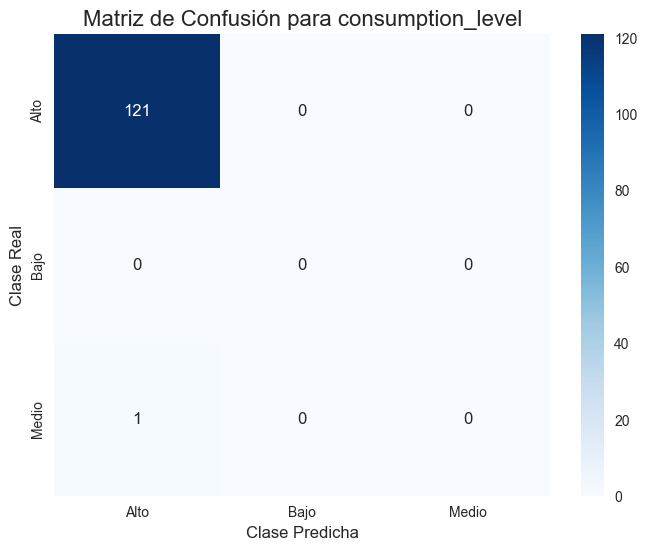

In [445]:
# Se realizan predicciones en el conjunto de prueba.
y_pred_class = dtc.predict(X_test_class)
y_pred_proba_class = dtc.predict_proba(X_test_class) # Probabilidades (opcional)

# Calcular métricas de evaluación
accuracy_class = accuracy_score(y_test_class, y_pred_class)

print(f"\n--- Resultados de Evaluación para DecisionTreeClassifier ({target_class}) ---")
print(f"Accuracy: {accuracy_class:.4f}")

print("\nInforme de Clasificación:")
report = classification_report(y_test_class, y_pred_class, zero_division=0)
print(report)

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_class, y_pred_class, labels=dtc.classes_) # Usar dtc.classes_ para el orden

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dtc.classes_, yticklabels=dtc.classes_)
plt.title(f'Matriz de Confusión para {target_class}', fontsize=16)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

## 3.5. Optimización de Hiperparámetros

In [446]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de clasificación.
param_grid_dtc = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [4, 6, 8, 10],
    'min_samples_leaf': [4, 6, 8, 10],
    'criterion': ['entropy'],
    'class_weight': [None, 'balanced']
}

# Usar TimeSeriesSplit si la secuencia importa para la clasificación
tscv_class = TimeSeriesSplit(n_splits=5)

grid_search_dtc = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dtc,
    cv=tscv_class, # o un entero para KFold si el split no es cronológico
    scoring='f1_weighted', # Usar f1_weighted o f1_macro si hay desbalance
    verbose=1,
    n_jobs=-1
)

grid_search_dtc.fit(X_train_class, y_train_class)

print(f"\nMejores Hiperparámetros para DecisionTreeClassifier: {grid_search_dtc.best_params_}")
print(f"Mejor puntuación (F1-weighted) en CV: {grid_search_dtc.best_score_:.4f}")

best_dtc = grid_search_dtc.best_estimator_

# Re-evaluar el mejor modelo en el conjunto de prueba
y_pred_best_dtc = best_dtc.predict(X_test_class)
print("\nInforme de Clasificación del Mejor Modelo DTC en Test Set:")
print(classification_report(y_test_class, y_pred_best_dtc, zero_division=0))

Fitting 5 folds for each of 160 candidates, totalling 800 fits

Mejores Hiperparámetros para DecisionTreeClassifier: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 4}
Mejor puntuación (F1-weighted) en CV: 0.7434

Informe de Clasificación del Mejor Modelo DTC en Test Set:
              precision    recall  f1-score   support

        Alto       0.99      1.00      1.00       121
       Medio       0.00      0.00      0.00         1

    accuracy                           0.99       122
   macro avg       0.50      0.50      0.50       122
weighted avg       0.98      0.99      0.99       122



## 3.6. Guardado del Modelo con Mejor Conjunto de Hiperparaáetros

In [447]:
model_filename_class = f'../models/dtc_{target_classification.lower().replace(" ", "_")}_level.joblib'
joblib.dump(dtc, model_filename_class) # O best_dtc
print(f"\nModelo de clasificación guardado en: {model_filename_class}")


Modelo de clasificación guardado en: ../models/dtc_wind_energy_level.joblib
